<a href="https://colab.research.google.com/github/Chizzy-codes/CIFAR_10_Image_Classification_Project/blob/master/Image_Classification_Using_CIFAR10_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# needs to be run on colab or kaggle notebook
!pip install tensorflow-gpu

     |████████████████████████████████| 320.4MB 46kB/s 


# Importing the needed libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers.experimental import preprocessing

%matplotlib inline
sns.set()

# The current state of the art performance for this dataset is 99 accuracy (GPipe: Efficient Training of Giant Neural Networks using pipeline parallelism)

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets
from tensorflow.keras.applications.vgg16 import preprocess_input

In [4]:
# Setting random seed for reproducible results

from tensorflow.python.client import device_lib 

np.random.seed(42)
tf.random.set_seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8782620242756002389
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5802259631726605253
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 18095471703029348698
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14613293312
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5863395658410371058
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


# Importing the cifar 10 dataset
- Data downloaded from https://www.cs.toronto.edu/~kriz/cifar.html

In [ ]:
image_size = 32
num_channels = 3
image_size_flat = image_size * image_size * num_channels
num_classes = 10
train_files = 5
image_per_file = 10000
num_train_images = 50000

# functions for processing raw cifar file from memory


# change the raw data to float and normalize them by dividing by the highest pixel value 255
def convert(raw):
    raw_float = np.array(raw, dtype=float)
    #reshape into 4 dimensions
    images = raw_float.reshape(-1, num_channels, image_size, image_size)
    # reorder image shape indices
    images = images.transpose([0,2,3,1])
    return images

# load pickle files and return the images and class label
def load(filename):
    #load pickle files
    with open(filename, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
    
    # get raw images and label
    raw_images = data[b'data']
    labels = np.array(data[b'labels'])
    
    # convert the images
    images = convert(raw_images)
    
    return images, labels

# load the name of the classes in the cifar-10 dataset
def load_class_names():
    with open('data/batches.meta', 'rb') as f:
        raw = pickle.load(f, encoding='bytes')[b'label_names']
    
    # convert from binary strings to strings
    names = [x.decode('utf-8') for x in raw]
    
    return names

# Load all the 5 batch files of the cifar 10 dataset and combine them in a single training dataset
def load_train_data():
    # create placeholder image and label arrays
    images = np.zeros(shape=[num_train_images, image_size, image_size, num_channels], dtype='float')
    labels = np.zeros(shape=[num_train_images], dtype='int')
    
    # begin index for the current batch
    begin = 0
    
    # for each data file
    for i in range(train_files):
        # load images and labels
        image_batch, label_batch = load('data/data_batch_' + str(i+1))
        
        # number of images for this batch
        num_images = len(image_batch)
        
        # End-index for the current batch
        end = begin + num_images
        
        # store images in an array
        images[begin:end, :] = image_batch
        
        # store the labels in an array
        labels[begin:end] = label_batch
        
        # the begin index is for the next batch is the current end-index
        begin = end
        
    return images, labels, OneHotEncoder(sparse=False).fit_transform(labels.reshape(-1, 1))


# load test data
def load_test_data():
    images, labels = load('data/test_batch')
    
    return images, labels, OneHotEncoder(sparse=False).fit_transform(labels.reshape(-1, 1))        

In [ ]:
# load data

X_train, y_train, y_train_oh = load_train_data()
X_test, y_test, y_test_oh = load_test_data()
classes = load_class_names()

In [ ]:
X_train.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [5]:
# Alternatively u can load the cifar10 dataset using keras dataset 

(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [ ]:
y_train.shape, y_test.shape

((50000, 1), (10000, 1))

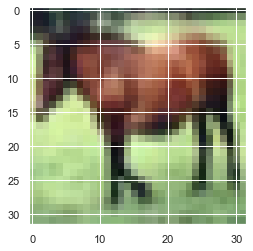

In [ ]:
x = X_train.copy()/255

plt.imshow(x[7])

In [ ]:
y_train.shape

(50000, 1)

In [ ]:
y_train[4]

array([1], dtype=uint8)

In [ ]:
# Reshaping y_train, and y_test
y_train1 = y_train.reshape(-1,)


In [ ]:
classes = ['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

deer


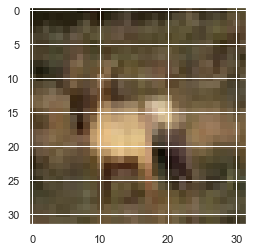

In [ ]:
print(classes[y_train1[3]])
plt.imshow(x[3])

# After investigating the images,  we can say that the images would benefit from horizontal flip and random brightness data augmentations

In [6]:
# Normalising the values by dividing by the maximum pixel value (255) if you loaded data from tensorflow library

X_train =  X_train/255
X_test = X_test/255


In [7]:
# converting the labels values to one hot encoded values

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

## Use sklearn split the training data into train / validate datasets

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

ss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, test_index in ss.split(X_train, y_train):
    X_train, X_val = X_train[train_index], X_train[test_index]
    y_train, y_val = y_train[train_index], y_train[test_index]

In [ ]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((45000, 32, 32, 3), (5000, 32, 32, 3), (45000, 10), (5000, 10))

### use the X_val and y_val as validation data

# Training models on the train and test data

## Using an Artificial Neural Network

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(32,32,3)))
model.add(Dense(3072, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(10, activation='sigmoid'))

print(model.summary())

model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, y_train,  validation_data=[X_val, y_val], epochs=40, callbacks=[es])

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_16 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_52 (Dense)             (None, 3072)              9440256   
_________________________________________________________________
dense_53 (Dense)             (None, 1024)              3146752   
_________________________________________________________________
dense_54 (Dense)             (None, 10)                10250     
Total params: 12,597,258
Trainable params: 12,597,258
Non-trainable params: 0
_________________________________________________________________
None
Train on 45000 samples, validate on 5000 samples
Epoch 1/40
45000/45000 [==============================] - 19s 429us/sample - loss: 1.8733 - accuracy: 0.3294 - val_loss: 2.2020 - val_accuracy: 0.2298
Epoch 2/40
45000/45000 [==========

In [ ]:
model.evaluate(X_test, y_test_oh) 

10000/10000 [==============================] - 2s 207us/sample - loss: 1.5203 - accuracy: 0.4728


[1.5202577260971069, 0.4728]

In [ ]:
pred = model.predict(X_test)
pred = [np.argmax(x) for x in pred]
print(classification_report(y_test, pred))
print('\n')
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.65      0.50      0.56      1000
           1       0.80      0.31      0.45      1000
           2       0.34      0.55      0.42      1000
           3       0.32      0.31      0.31      1000
           4       0.69      0.12      0.21      1000
           5       0.36      0.50      0.42      1000
           6       0.46      0.70      0.55      1000
           7       0.51      0.65      0.57      1000
           8       0.79      0.49      0.60      1000
           9       0.50      0.64      0.56      1000

    accuracy                           0.48     10000
   macro avg       0.54      0.48      0.47     10000
weighted avg       0.54      0.48      0.47     10000



[[498   8 183  32   1  47  55  66  55  55]
 [ 40 309  30  65   2  34  63  50  34 373]
 [ 33   3 547  75  16 104 120  87   3  12]
 [  5   2 106 308   5 312 171  64   6  21]
 [ 21   2 347  63 124 106 183 137   7  10]
 [  5   1 140 173   6 50

## The artificial neural network preformed poorly on the test data getting 48 percent accuracy. It performed best on class 8 (ship) and worst on class 4 (deer). Next we would try a convolution neural network which is more suited to images

# Convolution Neural Network

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing


#datagen = ImageDataGenerator(horizontal_flip=True)

# zca_whitening=True

#datagen.fit(X_train, seed=42)

In [17]:
from tensorflow.keras.layers import Conv2D, MaxPool2D
cnn = Sequential()
# Upsampling our input images due to their low resolution to enable or model to detect more patterns
#cnn.add(tf.keras.layers.UpSampling2D(size=(2,2)))

# data augumentation
cnn.add(preprocessing.RandomFlip('horizontal')) # flip left to right
#cnn.add(preprocessing.RandomContrast(0.5)) # contrast change by up to 50%

# convolution layer
cnn.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
               padding='same', input_shape=(32, 32, 3)))
cnn.add(MaxPool2D((2, 2)))

cnn.add(Conv2D(filters=32, kernel_size=(3, 3),
               activation='relu', padding='same'))
cnn.add(MaxPool2D((2, 2)))

cnn.add(Conv2D(filters=64, kernel_size=(3, 3),
               activation='relu', padding='same'))
cnn.add(MaxPool2D((2, 2)))

# DNN classifier layer
cnn.add(Flatten())
cnn.add(Dense(512, activation='relu'))
cnn.add(Dropout(0.2))

cnn.add(Dense(256, activation='relu'))
cnn.add(Dropout(0.2))

# cnn.add(BatchNormalization())

cnn.add(Dense(10, activation='softmax'))

#print(cnn.summary())

cnn.compile(loss='categorical_crossentropy',
            optimizer='adam', metrics=['accuracy'])

#callback = []
def decay(epoch):
    """ This method create the alpha"""
    return 0.001 / (1 + 1 * 30)

#callback += [tf.keras.callbacks.LearningRateScheduler(decay, verbose=1)]
#callback += [tf.keras.callbacks.ModelCheckpoint('cifar10.h5', save_best_only=True, mode='min')]

callback = [tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')]
cnn.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=callback, epochs=40, batch_size=128)

Epoch 1/40
352/352 [==============================] - 3s 8ms/step - loss: 1.5934 - accuracy: 0.4156 - val_loss: 1.2854 - val_accuracy: 0.5452
Epoch 2/40
352/352 [==============================] - 3s 7ms/step - loss: 1.2017 - accuracy: 0.5695 - val_loss: 1.0616 - val_accuracy: 0.6224
Epoch 3/40
352/352 [==============================] - 3s 7ms/step - loss: 1.0189 - accuracy: 0.6394 - val_loss: 0.9447 - val_accuracy: 0.6720
Epoch 4/40
352/352 [==============================] - 3s 7ms/step - loss: 0.9095 - accuracy: 0.6820 - val_loss: 0.8568 - val_accuracy: 0.6968
Epoch 5/40
352/352 [==============================] - 3s 7ms/step - loss: 0.8379 - accuracy: 0.7080 - val_loss: 0.8396 - val_accuracy: 0.7014
Epoch 6/40
352/352 [==============================] - 3s 7ms/step - loss: 0.7649 - accuracy: 0.7322 - val_loss: 0.7603 - val_accuracy: 0.7270
Epoch 7/40
352/352 [==============================] - 3s 7ms/step - loss: 0.7203 - accuracy: 0.7489 - val_loss: 0.7447 - val_accuracy: 0.7412
Epoch 

In [18]:
cnn.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.6904 - accuracy: 0.7812


[0.6904495358467102, 0.7811999917030334]

## Results 
- with same padding, Accuracy: 0.7498 , loss: 1.1980 without data augumentation
- with data augumentation, Accuracy: 0.7811999

In [ ]:
#pred = cnn.predict(X_test)
#pred

y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [ ]:
pred1 = cnn.predict(X_test)

y_test = [np.argmax(x) for x in y_test]
pred1 = [np.argmax(x) for x in pred1]
print(classification_report(y_test, pred1))
print('\n')
print(confusion_matrix(y_test, pred1))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1000
           1       0.86      0.89      0.87      1000
           2       0.74      0.63      0.68      1000
           3       0.56      0.59      0.57      1000
           4       0.69      0.77      0.72      1000
           5       0.64      0.68      0.66      1000
           6       0.78      0.82      0.80      1000
           7       0.82      0.79      0.80      1000
           8       0.88      0.85      0.87      1000
           9       0.86      0.82      0.84      1000

    accuracy                           0.76     10000
   macro avg       0.77      0.76      0.76     10000
weighted avg       0.77      0.76      0.76     10000



[[799  21  36  24  28   7   7  14  36  28]
 [ 10 885   8  10   5   2   8   2  25  45]
 [ 55   7 629  66  89  66  53  23   7   5]
 [ 12   3  37 589  73 170  63  31   9  13]
 [ 16   3  43  54 765  32  43  35   4   5]
 [ 10   0  25 164  37 68

## What i noticed is that our cnn classifier performed much better than our ann classifier(71 percent vs 48 percent accuracy). It also performed better on certain image classes and less on others
- It performed best on image class 1 (automobile)
- it performed performed the least on image class 3 (cat)

Comparing the two models,  they both performed well on class 8(ship) and poorly on class 3(cat)

# Using transfer learning with VGG16 model

In [ ]:
# Reload the data

#X_train, y_train, y_train_oh = load_train_data()
#X_test, y_test, y_test_oh = load_test_data()

(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

# Preprocess the data

def preprocess(X, y):
    X = X.astype('float32')
    #using preprocess VGG16 method by default to scale images and their values
    X = preprocess_input(X)
    # changind labels to one-hot representation
    y = tf.keras.utils.to_categorical(y, 10)
    return (X, y)

X_train, y_train = preprocess(X_train, y_train)
X_test, y_test = preprocess(X_test, y_test)

ss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, test_index in ss.split(X_train, y_train):
    X_train, X_val = X_train[train_index], X_train[test_index]
    y_train, y_val = y_train[train_index], y_train[test_index]

y_test.shape

(10000, 10)

In [19]:
# load the base of vgg16

pt_base = tf.keras.applications.vgg16.VGG16(
    include_top=False, weights='imagenet', pooling='max', input_shape=(32, 32, 3))

#pt_base.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


In [26]:
# attach the head

tf_model = Sequential()
# Upsampling our images
tf_model.add(tf.keras.layers.UpSampling2D(size=(2,2)))
#tf_model.add(tf.keras.layers.Conv2DTranspose(3, (3,3),strides=(2,2), padding='same'))

# data augumentation
tf_model.add(preprocessing.RandomFlip('horizontal')) # flip left to right
tf_model.add(preprocessing.RandomContrast(0.5)) # contrast change by up to 50%

tf_model.add(pt_base)

tf_model.add(Flatten())

tf_model.add(Dense(512, activation='relu'))
tf_model.add(Dropout(0.2))
#tf_model.add(BatchNormalization())

tf_model.add(Dense(256, activation='relu'))
tf_model.add(Dropout(0.2))
#tf_model.add(BatchNormalization())

tf_model.add(Dense(10, activation='softmax'))

#print(tf_model.summary())

tf_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callback = []
def decay(epoch):
    """ This method create the alpha"""
    return 0.001 / (1 + 1 * 30)

callback += [tf.keras.callbacks.LearningRateScheduler(decay, verbose=1)]
callback += [tf.keras.callbacks.ModelCheckpoint('cifar10.h5', save_best_only=True, mode='min')]

#callback += [tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')]


tf_model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=callback, epochs=2, batch_size=128)


Epoch 00001: LearningRateScheduler reducing learning rate to 3.2258064516129034e-05.
Epoch 1/2
352/352 [==============================] - 99s 280ms/step - loss: 0.1236 - accuracy: 0.9620 - val_loss: 0.3467 - val_accuracy: 0.9256

Epoch 00002: LearningRateScheduler reducing learning rate to 3.2258064516129034e-05.
Epoch 2/2
352/352 [==============================] - 100s 283ms/step - loss: 0.0201 - accuracy: 0.9939 - val_loss: 0.3308 - val_accuracy: 0.9318


In [27]:
tf_model.evaluate(X_test, y_test)

313/313 [==============================] - 8s 25ms/step - loss: 0.3663 - accuracy: 0.9240


[0.366346150636673, 0.9240000247955322]

# Result
- using a pretrained base - accuracy: 0.9240, loss: 0.3663
- using an untrained base - accuracy: 0.80, loss: 0.80

In [28]:
pred2 = tf_model.predict(X_test)

pred2 = [np.argmax(x) for x in pred2]
y_test = [np.argmax(x) for x in y_test]

print(classification_report(y_test, pred2))
print('\n')
print(confusion_matrix(y_test, pred2))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93      1000
           1       0.94      0.97      0.95      1000
           2       0.91      0.92      0.92      1000
           3       0.83      0.87      0.85      1000
           4       0.95      0.91      0.93      1000
           5       0.93      0.79      0.86      1000
           6       0.92      0.97      0.94      1000
           7       0.96      0.95      0.96      1000
           8       0.95      0.96      0.96      1000
           9       0.96      0.93      0.94      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



[[958   2   6   1   0   0   0   2  27   4]
 [  5 972   0   0   0   0   0   0   4  19]
 [ 24   0 919  14  11   4  20   4   4   0]
 [ 12   3  15 872   9  38  34   8   5   4]
 [  8   2  27  18 909   8  14  12   2   0]
 [  4   2  19 134  14 79

# Things i learnt from this project
- Data augumentation helps but doesnt have a huge impact on this dataset due to the low pixel resolution (1-3) percent increase
- Running the model with a constant learning rate and a model checkpoint callback helped to improve the test accuracy score by 5 percent (from 80% to 85%)
- Adding a 2D upsampling layer was the biggest contributor to the model accuracy, it accounted for a little above 7 test percent accuracy increase
- Using a 2D upsampling layer gave better performance on this dataset compared to the Conv2D Transpose layer
- DropOut regularization help to improve testing and validation accuracy by reducing overfitting
- Increasing the 2d upsampling layer's size from (2,2) had no obvious effect on the models test accuracy score
- Applying transfer learning by using a pretrained base gave us a lower accuracy score comparared to when the base was untrained (test accuracy in 70s vs test accuracy in 90s)
- our Vgg16 (untrained) base with 2d upsampling, constant learning rate, data augumentation and model checkpoint callback gave the best result of 0.91 accuracy score for the cifar 10 dataset.